! uv pip install jax[cuda12] --force-reinstall
# Imports

In [1]:
import mmml
import ase
import os
from pathlib import Path
# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".45"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
import jax
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())


[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


In [2]:
from mmml.physnetjax import *

In [3]:
from mmml.physnetjax.physnetjax.calc.helper_mlp import get_ase_calc
reshifted = False

In [4]:
from mmml.physnetjax.physnetjax.models import model as model
from mmml.physnetjax.physnetjax.models.model import EF
from mmml.physnetjax.physnetjax.training.training import train_model


# Data

In [5]:
from mmml.physnetjax.physnetjax.data.data import prepare_datasets
from mmml.physnetjax.physnetjax.data.batches import prepare_batches_jit

In [6]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(42), 2)
BATCHSIZE = 64

In [7]:
# Initialize random key for data loading
if 'data_key' not in globals():
    data_key = jax.random.PRNGKey(42)


data_file = "/pchem-data/meuwly/boittier/home/mmml/mmml/data/fixed-acetone-only_MP2_21000.npz"

print(f"Loading data from: {data_file}")

# Prepare datasets
train_data, valid_data = prepare_datasets(
    data_key, 
    10500,  # num_train
    10500,  # num_valid
    [data_file], 
    natoms=20
)


Loading data from: /pchem-data/meuwly/boittier/home/mmml/mmml/data/fixed-acetone-only_MP2_21000.npz
dataR (21000, 20, 3)
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
D (21000, 3)
Q 1 (21000,) 21000
Q (21000,)


In [8]:
files = [data_file]
train_size = 20000 
valid_size = 1000
NATOMSMAX = 20

train_data, valid_data = prepare_datasets(data_key, train_size, valid_size, files, natoms=NATOMSMAX)

dataR (21000, 20, 3)
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
D (21000, 3)
Q 1 (21000,) 21000
Q (21000,)


In [9]:
import openqdc

In [10]:
train_data, valid_data = prepare_datasets(data_key, train_size, valid_size, files, natoms=NATOMSMAX)



valid_batches = prepare_batches_jit(data_key, valid_data, BATCHSIZE, num_atoms = NATOMSMAX)

dataR (21000, 20, 3)
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
D (21000, 3)
Q 1 (21000,) 21000
Q (21000,)


In [11]:
atom_energies = {1: -13.717939590030356 ,
6: -1029.831662730747 ,
7: -1485.40806126101 ,
8: -2042.7920344362644 ,
16: -10831.264715514206 ,}

In [12]:
XXX = train_data["E"] / (train_data["Z"].sum(axis=1))
XXX .flatten().flatten().mean()

np.float64(-1.3306833009327976)

## Save Checkpoint as JSON (for portability)

After training, you can save checkpoints as JSON files for easy loading without requiring orbax or pickle. This is useful for sharing models or loading in different environments.


In [13]:
# ========================================================================
# SAVE CHECKPOINT AS JSON (no orbax/pickle required for loading)
# ========================================================================
# This function converts JAX parameters to JSON-serializable format
# and saves them along with model configuration

def save_checkpoint_as_json(params, model, save_dir, epoch=None, best_loss=None):
    """
    Save model checkpoint as JSON files for portability.
    
    This saves:
    - params.json: Model parameters (converted from JAX arrays to lists)
    - model_config.json: Model configuration
    
    Args:
        params: Model parameters (JAX PyTree)
        model: Model instance
        save_dir: Directory to save checkpoint files
        epoch: Optional epoch number
        best_loss: Optional best loss value
    """
    import json
    from pathlib import Path
    
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Helper function to convert JAX arrays to JSON-serializable format
    def jax_to_json(obj):
        """Recursively convert JAX arrays to lists for JSON serialization."""
        if isinstance(obj, dict):
            return {k: jax_to_json(v) for k, v in obj.items()}
        elif isinstance(obj, (list, tuple)):
            return [jax_to_json(item) for item in obj]
        elif hasattr(obj, '__array__'):  # JAX/NumPy arrays
            return jnp.asarray(obj).tolist()
        elif isinstance(obj, (int, float, str, bool, type(None))):
            return obj
        else:
            # Try to convert to array if possible
            try:
                return jnp.asarray(obj).tolist()
            except:
                return str(obj)
    
    # Save parameters as JSON
    params_json = jax_to_json(params)
    params_path = save_dir / "params.json"
    
    print(f"Saving parameters to: {params_path}")
    with open(params_path, 'w') as f:
        json.dump(params_json, f, indent=2)
    print(f"  ✓ Saved {params_path}")
    
    # Extract and save model configuration
    model_config = {}
    
    # Try to extract model attributes
    if hasattr(model, 'return_attributes'):
        # PhysNet EF models
        model_config = model.return_attributes()
    elif hasattr(model, '__dict__'):
        # Try to get config from model attributes
        config_attrs = [
            'features', 'cutoff', 'max_degree', 'num_iterations',
            'num_basis_functions', 'max_atomic_number', 'n_res',
            'zbl', 'efa', 'charges', 'natoms', 'total_charge'
        ]
        for attr in config_attrs:
            if hasattr(model, attr):
                value = getattr(model, attr)
                # Convert JAX arrays to Python types
                if hasattr(value, '__array__'):
                    value = float(jnp.asarray(value).item()) if value.size == 1 else jax_to_json(value)
                model_config[attr] = value
    else:
        print("Warning: Could not extract model configuration")
    
    # Save model config as JSON
    config_path = save_dir / "model_config.json"
    print(f"Saving model config to: {config_path}")
    with open(config_path, 'w') as f:
        json.dump(model_config, f, indent=2)
    print(f"  ✓ Saved {config_path}")
    
    # Optionally save metadata
    if epoch is not None or best_loss is not None:
        metadata = {}
        if epoch is not None:
            metadata['epoch'] = int(epoch)
        if best_loss is not None:
            # Convert JAX array to float if needed
            if hasattr(best_loss, '__array__'):
                metadata['best_loss'] = float(jnp.asarray(best_loss).item())
            else:
                metadata['best_loss'] = float(best_loss)
        
        metadata_path = save_dir / "metadata.json"
        print(f"Saving metadata to: {metadata_path}")
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        print(f"  ✓ Saved {metadata_path}")
    
    print(f"\n✓ Checkpoint saved as JSON in: {save_dir}")
    print(f"  Files created:")
    print(f"    - {params_path.name}")
    print(f"    - {config_path.name}")
    if epoch is not None or best_loss is not None:
        print(f"    - metadata.json")
    print(f"\n  These files can be loaded without orbax or pickle!")
    
    return save_dir


In [14]:
model = EF(
    features=64,
    max_degree = 1,
    num_basis_functions=64,
    num_iterations = 2,
    n_res=5,
    cutoff = 8.0,
    max_atomic_number = 40,
    zbl=False,
    efa=False,
    charges=True,
)
model

EF(
    # attributes
    features = 64
    max_degree = 1
    num_iterations = 2
    num_basis_functions = 64
    cutoff = 8.0
    max_atomic_number = 40
    charges = True
    natoms = 60
    total_charge = 0
    n_res = 5
    zbl = False
    debug = False
    efa = False
    use_energy_bias = True
)

## Training

In [ ]:
do_training = True
if do_training:
    # uid = "test-84aa02d9-e329-46c4-b12c-f55e6c9a2f94"
    uid = "pyhsnetacetone-d38b2d5c-b24d-432b-83b4-801ff726dbde"
    uid = "eq_acetone-a114f328-a678-4999-904a-ef8ff78a7eb1"
    # SCICORE = Path('/scicore/home/meuwly/boitti0000/ckpts')
    SCICORE = Path("/pchem-data/meuwly/boittier/home/ckpts")
    RESTART=str(SCICORE / f"{uid}")
    params_out = train_model(
        train_key,
        model,
        train_data,
        valid_data, 
        num_epochs = 5000,
        learning_rate=0.0001,
        batch_size=BATCHSIZE,
        num_atoms=NATOMSMAX,
        energy_weight=10000,
        restart=RESTART,
        conversion={'energy': 1, 'forces': 1},
        print_freq=1,
        name='eq_acetone',
        best=False,
        optimizer=None,
        transform=None,
        schedule_fn="constant",
        objective='valid_loss',
        ckpt_dir=SCICORE,
        log_tb=False,
        batch_method="default",
        batch_args_dict=None,
        data_keys=('R', 'Z', 'F', "N", 'E', 'D', 'batch_segments'),
        
    )

                                            Train Data                                             
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ R              ┃ Z           ┃ F              ┃ E          ┃ N          ┃ D          ┃ Q        ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━┩
│ (20000, 20, 3) │ (20000, 20) │ (20000, 20, 3) │ (20000, 1) │ (20000, 1) │ (20000, 3) │ (20000,) │
└────────────────┴─────────────┴────────────────┴────────────┴────────────┴────────────┴──────────┘

                                      Validation Data                                       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┓
┃ R             ┃ Z          ┃ F             ┃ E         ┃ N         ┃ D         ┃ Q       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━┩
│ (1000, 20, 3) │ (1000, 20) │ (1000, 20, 3) │ (1000, 1) │ (1000, 1) │ (1000, 3) │ (1000,) │
└───────────────┴────────────┴───────────────┴───────────┴───────────┴───────────┴─────────┘

Using default (fat) batching method


Training Routine

.,,uod8B8bou,,.
              ..,uod8BBBBBBBBBBBBBBBBRPFT?l!i:.
         ,=m8BBBBBBBBBBBBBBBRPFT?!||||||||||||||
         !...:!TVBBBRPFT||||||||||!!^^""'   ||||
         !.......:!?|||||!!^^""'            ||||
         !.........||||                     ||||
         !.........||||  ##                 ||||
         !.........||||      PhysNet        ||||
         !.........||||      JAX            ||||
         !.........||||                     ||||
         !.........||||                     ||||
         `.........||||                    ,||||
          .;.......||||               _.-!!|||||
   .,uodWBBBBb.....||||       _.-!!|||||||||!:'
!YBBBBBBBBBBBBBBb..!|||:..-!!|||||||!iof68BBBBBb....
!..YBBBBBBBBBBBBBBb!!||||||||!iof68BBBBBBRPFT?!::   `.
!....YBBBBBBBBBBBBBBbaaitf68BBBBBBRPFT?!:::::::::     `.
!......YBBBBBBBBBBBBBBBBBBBRPFT?!::::::;:!^"`;:::       `.
!........YBBBBBBBBBBRPFT?!::::::::::^''...::::::;         iBBbo.
`..........YBRPFT?!::::::::::::::::::::::::;iof68bo.      WBBBBbo.
  `..........:::::::::::::::::::::::;iof688888888888b.     `YBBBP^'
    `........::::::::::::::::;iof688888888888888888888b.     `
      `......:::::::::;iof688888888888888888888888888888b.
        `....:::;iof688888888888888888888888888888888899fT!
          `..::!8888888888888888888888888888888899fT|!^"'
            `' !!988888888888888888888888899fT|!^"'
                `!!8888888888888888899fT|!^"'
                  `!988888888899fT|!^"'
                    `!9899fT|!^"'
                      `!^"'

DATA_PATH: /pchem-data/meuwly/boittier/home/mmml/mmml/physnetjax/data

LOGS_PATH: /pchem-data/meuwly/boittier/home/mmml/mmml/physnetjax/logs

ANALYSIS_PATH: /pchem-data/meuwly/boittier/home/mmml/mmml/physnetjax/analysis

MAIN_PATH: /pchem-data/meuwly/boittier/home/mmml/mmml/physnetjax

PYCHARMM_DIR: None

Start Time:  22:10:08

                                                Optimizer Arguments                                                
┏━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━┳━━━━━━┳━━━━━━━┓
┃ optimizer ┃ optimized_… ┃ schedule_fn ┃ scheduling… ┃ transform ┃ reduce_tra… ┃ clip_glob… ┃ b1  ┃ b2   ┃ eps   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━╇━━━━━━╇━━━━━━━┩
│ None      │ GradientTr… │ constant    │ <function   │ None      │ GradientTr… │ 10.0       │ 0.9 │ 0.99 │ 0.001 │
│           │ chain.<loc… │             │ constant_s… │           │ reduce_on_… │            │     │      │       │
│           │ at          │             │ at          │           │ at          │            │     │      │       │
│           │ 0x14679c29… │             │ 0x14679c43… │           │ 0x14679c29… │            │     │      │       │
│           │ update=<fu… │             │             │           │ update=<fu… │            │     │      │       │
│           │ chain.<loc… │             │             │           │ reduce_on_… │            │     │      │       │
│           │ at          │             │             │           │ at          │            │     │      │       │
│           │ 0x14679c29… │             │             │           │ 0x14679c29… │            │     │      │       │
└───────────┴─────────────┴─────────────┴─────────────┴───────────┴─────────────┴────────────┴─────┴──────┴───────┘

                                    Training Parameters                                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ energy_weight ┃ forces_weight ┃ dipole_weight ┃ charges_weight ┃ batch_size ┃ num_atoms ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 10000         │ 52.91         │ 27.21         │ 14.39          │ 64         │ 20        │
└───────────────┴───────────────┴───────────────┴────────────────┴────────────┴───────────┘

                                                  Training Style                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ restart                                      ┃ best  ┃ data_keys                                   ┃ objective  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/ckpts/eq_a… │ False │ ('R', 'Z', 'F', 'N', 'E', 'D',              │ valid_loss │
│                                              │       │ 'batch_segments')                           │            │
└──────────────────────────────────────────────┴───────┴─────────────────────────────────────────────┴────────────┘

                                                Validation Batch[0]                                                
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ R        ┃ Z       ┃ F        ┃ N     ┃ E       ┃ D       ┃ dst_idx  ┃ src_idx  ┃ batch_m… ┃ batch_s… ┃ atom_m… ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ (1280,   │ (1280,) │ (1280,   │ (64,) │ (64, 1) │ (64, 3) │ (24320,) │ (24320,) │ (24320,) │ (1280,)  │ (1280,) │
│ 3)       │         │ 3)       │       │         │         │          │          │          │          │         │
└──────────┴─────────┴──────────┴───────┴─────────┴─────────┴──────────┴──────────┴──────────┴──────────┴─────────┘

Extra Validation Info:
Z: Array[1000, 20] i32 n=20000 (78Kb) x∈[0, 8] μ=3.038 σ=2.769 cpu:0
R: Array[1000, 20, 3] n=60000 (0.2Mb) x∈[-17.661, 18.309] μ=-1.848 σ=7.122 cpu:0
E: Array[1000, 1] 3.9Kb x∈[-82.149, -40.481] μ=-77.528 σ=12.309 cpu:0
N: Array[1000, 1] i32 3.9Kb x∈[10, 20] μ=18.990 σ=3.013 cpu:0
F: Array[1000, 20, 3] n=60000 (0.2Mb) x∈[-4.446, 4.514] μ=3.099e-10 σ=0.959 cpu:0
D: Array[1000, 3] n=3000 (12Kb) x∈[-0.419, 0.412] μ=-0.014 σ=0.167 cpu:0
dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ char… ┃ cuto… ┃ debug ┃ efa   ┃ feat… ┃ max_… ┃ max_… ┃ n_res ┃ nato… ┃ num_b… ┃ num_… ┃ total… ┃ use_… ┃ zbl   ┃
┡━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ True  │ 8.0   │ False │ False │ 64    │ 40    │ 1     │ 5     │ 20    │ 64     │ 2     │ 0      │ True  │ False │
└───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴────────┴───────┴────────┴───────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/ckpts/e… │ epoch-1505 │ 1505  │ Array gpu:0 3.893 │ 2025-12-08 22:48:22.938315 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

Restoring from /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-a114f328-a678-4999-904a-ef8ff78a7eb1/epoch-1505
Restored keys: dict_keys(['best_loss', 'ema_params', 'epoch', 'lr_eff', 'model', 'model_attributes', 'objectives', 'opt_state', 'params', 'transform_state'])
Training resumed from step 1505, best_loss Array gpu:0 3.893


                                                                                Model Attributes                                                                                 
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ features ┃ max_degree ┃ num_iterations ┃ num_basis_functions ┃ cutoff ┃ max_atomic_number ┃ charges ┃ natoms ┃ total_charge ┃ n_res ┃ zbl   ┃ debug ┃ efa   ┃ use_energy_bias ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 64       │ 1          │ 2              │ 64                  │ 8.0    │ 40                │ True    │ 20     │ 0            │ 5     │ False │ False │ False │ True            │
└──────────┴────────────┴────────────────┴─────────────────────┴────────┴───────────────────┴─────────┴────────┴──────────────┴───────┴───────┴───────┴───────┴─────────────────┘

Output()

ERROR:asyncio:Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/pchem-data/meuwly/boittier/home/.conda/envs/mmml-gpu/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x14738aa528c0> is already entered
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-192737' coro=<_async_in_context.<locals>.run_in_context() done, defined at /pchem-data/meuwly/boittier/home/.local/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-192738' coro=<Kernel.shell_main() running at /pchem-data/meuwly/boittier/home/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /pchem-data/meuwly/boittier/home/.local/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>
ERROR:asynci

### Example: Save loaded checkpoint as JSON

After loading a checkpoint (e.g., from orbax), you can save it as JSON for easier loading later:


In [15]:
from mmml.physnetjax.physnetjax.restart.restart import get_last, get_params_model, get_params_model_with_ase

ERROR! Session/line number was not unique in database. History logging moved to new session 2059


In [16]:
uid = "pyhsnetacetone-d38b2d5c-b24d-432b-83b4-801ff726dbde"
uid = "eq_acetone-a114f328-a678-4999-904a-ef8ff78a7eb1"
SCICORE = Path('/scicore/home/meuwly/boitti0000/')
SCICORE = Path("/pchem-data/meuwly/boittier/home/ckpts")
RESTART=str(SCICORE / f"{uid}")
RESTART

# │ /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-a114f328-a678-4999-904a-ef8ff78a7eb1/epoch-9 │ 20:46:28  │     


# │ /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-472e0e91-11d3-4fc9-b773-ab5a68b4cc42/epoch-10 │ 20:43:48  │    


'/pchem-data/meuwly/boittier/home/ckpts/eq_acetone-a114f328-a678-4999-904a-ef8ff78a7eb1'

In [17]:
last= get_last(RESTART)
last 

Path('/pchem-data/meuwly/boittier/home/ckpts/eq_acetone-a114f328-a678-4999-904a-ef8ff78a7eb1/epoch-1505')

In [18]:
params, model, everything = get_params_model(last, return_everything=True)
params, model, everything

dict_keys(['opt_state', 'params', 'step'])


/pchem-data/meuwly/boittier/home/.conda/envs/mmml-gpu/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1345: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


                                                 Model Attributes                                                  
┏━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ char… ┃ cuto… ┃ debug ┃ efa   ┃ feat… ┃ max_… ┃ max_… ┃ n_res ┃ nato… ┃ num_b… ┃ num_… ┃ total… ┃ use_… ┃ zbl   ┃
┡━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ True  │ 8.0   │ False │ False │ 64    │ 40    │ 1     │ 5     │ 20    │ 64     │ 2     │ 0      │ True  │ False │
└───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴────────┴───────┴────────┴───────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/ckpts/e… │ epoch-1505 │ 1505  │ Array gpu:0 3.893 │ 2025-12-08 22:47:41.865652 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

({'params': {'Dense_0': {'0+': {'bias': Array[64] x∈[-0.343, 0.227] μ=-0.009 σ=0.098 gpu:0,
     'kernel': Array[64, 64] n=4096 (16Kb) x∈[-0.959, 0.740] μ=-0.004 σ=0.197 gpu:0},
    '1-': {'kernel': Array[64, 64] n=4096 (16Kb) x∈[-0.659, 0.765] μ=-0.002 σ=0.187 gpu:0}},
   'Dense_1': {'0+': {'bias': Array[64] x∈[-0.525, 0.173] μ=-0.057 σ=0.126 gpu:0,
     'kernel': Array[64, 64] n=4096 (16Kb) x∈[-0.620, 0.757] μ=0.002 σ=0.170 gpu:0},
    '1-': {'kernel': Array[64, 64] n=4096 (16Kb) x∈[-0.616, 0.579] μ=-0.001 σ=0.163 gpu:0}},
   'Dense_10': {'0+': {'bias': Array[64] x∈[-2.262, 2.260] μ=-0.021 σ=0.986 gpu:0,
     'kernel': Array[64, 64] n=4096 (16Kb) x∈[-0.454, 0.567] μ=0.002 σ=0.122 gpu:0}},
   'Dense_11': {'0+': {'bias': Array[64] x∈[-1.823, 2.110] μ=-0.167 σ=0.645 gpu:0,
     'kernel': Array[64, 64] n=4096 (16Kb) x∈[-0.399, 0.483] μ=-0.001 σ=0.122 gpu:0}},
   'Dense_12': {'0+': {'kernel': Array[64, 1] x∈[-0.237, 0.423] μ=0.002 σ=0.084 gpu:0}},
   'Dense_13': {'kernel': Array[1, 1] gpu

In [19]:
# Example: Save the loaded checkpoint as JSON
# This converts the orbax checkpoint to JSON format for portability
import jax.numpy as jnp
# Save the loaded params and model as JSON
json_save_dir = last / "json_checkpoint"
save_checkpoint_as_json(
    params=params,
    model=model,
    save_dir=json_save_dir,
    epoch=everything.get('epoch', None) if 'everything' in locals() else None,
    best_loss=everything.get('best_loss', None) if 'everything' in locals() else None
)

# Now you can load this checkpoint later using:
# from 3-sim.ipynb: load_model_parameters_json(json_save_dir, natoms=NATOMSMAX)
json_save_dir


Saving parameters to: /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-a114f328-a678-4999-904a-ef8ff78a7eb1/epoch-1505/json_checkpoint/params.json
  ✓ Saved /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-a114f328-a678-4999-904a-ef8ff78a7eb1/epoch-1505/json_checkpoint/params.json
Saving model config to: /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-a114f328-a678-4999-904a-ef8ff78a7eb1/epoch-1505/json_checkpoint/model_config.json
  ✓ Saved /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-a114f328-a678-4999-904a-ef8ff78a7eb1/epoch-1505/json_checkpoint/model_config.json
Saving metadata to: /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-a114f328-a678-4999-904a-ef8ff78a7eb1/epoch-1505/json_checkpoint/metadata.json
  ✓ Saved /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-a114f328-a678-4999-904a-ef8ff78a7eb1/epoch-1505/json_checkpoint/metadata.json

✓ Checkpoint saved as JSON in: /pchem-data/meuwly/boittier/home/ckpts/eq_acetone-a114f328-a678-4999-904a-ef8ff78a7eb1/epoch-1505/js

Path('/pchem-data/meuwly/boittier/home/ckpts/eq_acetone-a114f328-a678-4999-904a-ef8ff78a7eb1/epoch-1505/json_checkpoint')

In [20]:
list(json_save_dir.glob("*"))

[Path('/pchem-data/meuwly/boittier/home/ckpts/eq_acetone-a114f328-a678-4999-904a-ef8ff78a7eb1/epoch-1505/json_checkpoint/params.json'),
 Path('/pchem-data/meuwly/boittier/home/ckpts/eq_acetone-a114f328-a678-4999-904a-ef8ff78a7eb1/epoch-1505/json_checkpoint/model_config.json'),
 Path('/pchem-data/meuwly/boittier/home/ckpts/eq_acetone-a114f328-a678-4999-904a-ef8ff78a7eb1/epoch-1505/json_checkpoint/metadata.json')]

In [21]:
N = valid_batches[0]["N"][0]
R = valid_batches[0]["R"][:N]
Z = valid_batches[0]["Z"][:N]
atoms=ase.Atoms(Z , R)
atoms

Atoms(symbols='C3OH6C3OH6', pbc=False)

In [22]:
get_params_model_with_ase?

Signature: get_params_model_with_ase(pkl_path, model_path, atoms)
Docstring:
Load parameters and model from pickle files with ASE atoms.

Parameters
----------
pkl_path : str
    Path to parameters pickle file
model_path : str
    Path to model configuration pickle file
atoms : ase.Atoms
    ASE atoms object
    
Returns
-------
tuple
    Tuple of (parameters, model)
File:      ~/mmml/mmml/physnetjax/physnetjax/restart/restart.py
Type:      function

# Validation

In [23]:
from mmml.physnetjax.physnetjax.analysis.analysis import  *
model.natoms = 20
output = mmml.physnetjax.physnetjax.analysis.analysis.eval(valid_batches, model, params, batch_size=BATCHSIZE)
Es, Eeles, predEs, Fs, predFs, Ds, predDs, charges, outputs = output


15it [00:12,  1.17it/s]


In [24]:
ase_kcalmol = ase.units.kcal/ase.units.mol
1/ase_kcalmol

23.060548012069496

[np.float64(-87.32989501953125),
 np.float64(-87.09396362304688),
 np.float64(-86.15022277832031),
 np.float64(-80.48780059814453),
 np.float64(-40.143062591552734)]

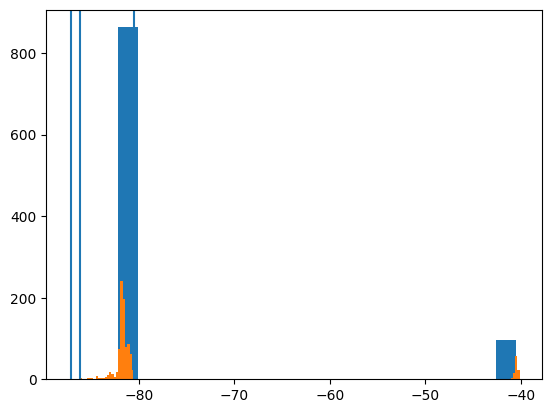

In [25]:
bin_count_edges = plt.hist(Es, bins=20)
bin_count_edges = plt.hist(predEs, bins=200)
bins = [bin_count_edges[1][0]]
for i, _ in enumerate(bin_count_edges[0]):
    if _ == 0 and bin_count_edges[0][i-1] != 0:
        bins.append(bin_count_edges[1][i-1])
        plt.axvline(bins[-1])
bins.append(bin_count_edges[1][-1])
bins
    

In [26]:
len(bins)

5

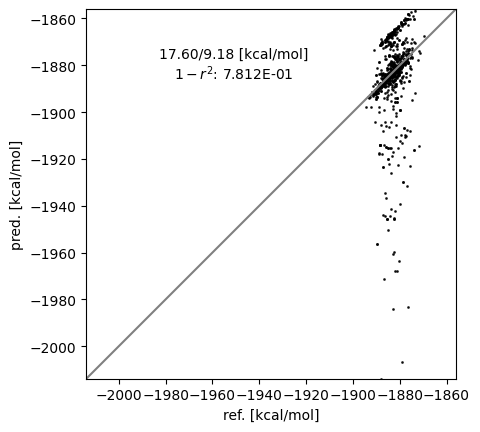

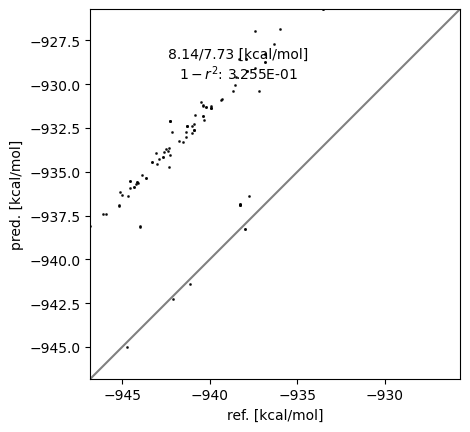

In [27]:
for i in range(len(bins)-1):
    monomers_idx = (Es < bins[1+i]) * (Es > bins[i])
    if np.sum(monomers_idx) != 0:
        # dimers_idx = Es < bins[1]
        ax = plt.gca()
        plot(Es[monomers_idx]/ase_kcalmol, predEs[monomers_idx]/ase_kcalmol, ax, units="kcal/mol", _property="", kde=False, s=1, diag=True)
        # plt.xlim(-42, -40)
        # plt.ylim(-42, -40)
        plt.show()
    # ax = plt.gca()
    # plot(Es[dimers_idx]/ase_kcalmol, predEs[dimers_idx]/ase_kcalmol, ax, units="kcal/mol", _property="", kde=False, s=1, diag=True)

<Axes: xlabel='ref. [kcal/mol]', ylabel='pred. [kcal/mol]'>

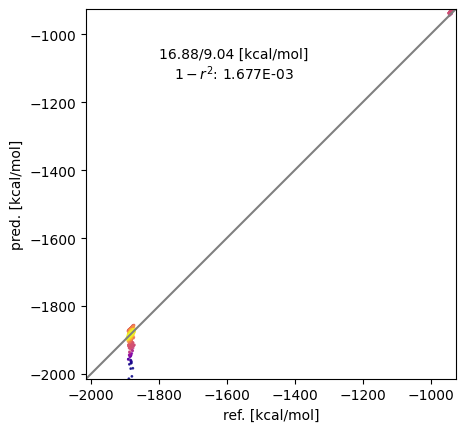

In [28]:
ax = plt.gca()
plot(Es/ase_kcalmol, predEs/ase_kcalmol, ax, units="kcal/mol", _property="", kde=True, s=1, diag=True)

<Axes: xlabel='ref. [kcal/mol]', ylabel='pred. [kcal/mol]'>

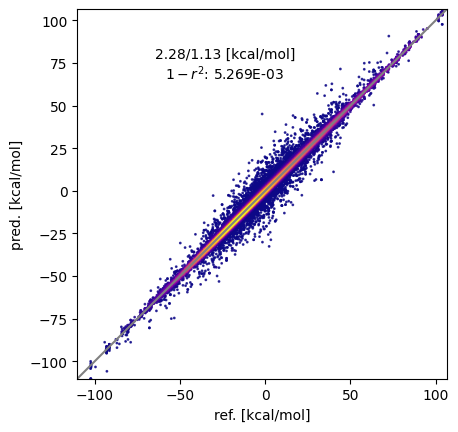

In [29]:
ax = plt.gca()
plot(Fs/ase_kcalmol, predFs/ase_kcalmol, ax, units="kcal/mol", _property="", kde=True, s=1, diag=True)

<Axes: xlabel='ref. [kcal/mol]', ylabel='pred. [kcal/mol]'>

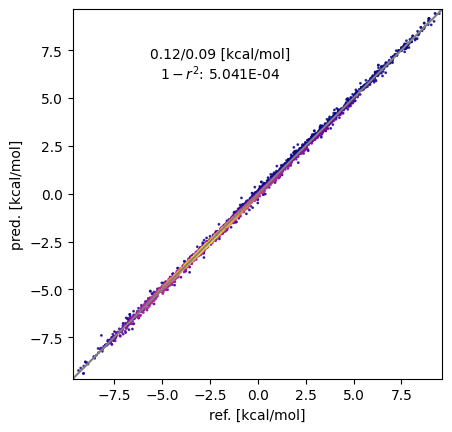

In [30]:
ax = plt.gca()
plot(Ds/ase_kcalmol, predDs/ase_kcalmol, ax, units="kcal/mol", _property="", kde=True, s=1, diag=True)

# Calculator

In [72]:
# !conda install pint
from mmml.pycharmmInterface import import_pycharmm
import pycharmm
from mmml.pycharmmInterface.mmml_calculator import setup_calculator, CutoffParameters

/pchem-data/meuwly/boittier/home/mmml/mmml/data/top_all36_cgenff.rtf
/pchem-data/meuwly/boittier/home/mmml/mmml/data/par_all36_cgenff.prm
CHARMM_HOME /pchem-data/meuwly/boittier/home/mmml/setup/charmm
CHARMM_LIB_DIR /pchem-data/meuwly/boittier/home/mmml/setup/charmm
  
 CHARMM>     BLOCK
 WARNING from DECODI -- Zero length string being converted to 0
 Block structure initialized with   3 blocks.
 All atoms have been assigned to block 1.
 All interaction coefficients have been set to unity.
  Setting number of block exclusions nblock_excldPairs=0
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>      0 atoms have been selected out of      0
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ANGLE 

In [73]:
?CutoffParameters

Init signature:
CutoffParameters(
    ml_cutoff: float = 2.0,
    mm_switch_on: float = 5.0,
    mm_cutoff: float = 1.0,
)
Docstring:      Parameters for ML and MM cutoffs and switching functions
Init docstring:
Args:
    ml_cutoff: Distance where ML potential is cut off
    mm_switch_on: Distance where MM potential starts switching on
    mm_cutoff: Final cutoff for MM potential
File:           ~/mmml/mmml/pycharmmInterface/cutoffs.py
Type:           type
Subclasses:     

In [74]:
ATOMS_PER_MONOMER = 10
N_MONOMERS = 2

In [75]:
?setup_calculator

Signature:
setup_calculator(
    ATOMS_PER_MONOMER,
    N_MONOMERS: 'int' = 2,
    ml_cutoff_distance: 'float' = 2.0,
    mm_switch_on: 'float' = 5.0,
    mm_cutoff: 'float' = 1.0,
    doML: 'bool' = True,
    doMM: 'bool' = True,
    doML_dimer: 'bool' = True,
    debug: 'bool' = False,
    ep_scale=None,
    sig_scale=None,
    model_restart_path=None,
    MAX_ATOMS_PER_SYSTEM: 'int' = 20,
    ml_energy_conversion_factor: 'float' = 1.0,
    ml_force_conversion_factor: 'float' = 1.0,
    cell=False,
    verbose: 'bool' = False,
    ml_reorder_indices=None,
    at_codes_override=None,
)
Docstring: <no docstring>
File:      ~/mmml/mmml/pycharmmInterface/mmml_calculator.py
Type:      function

In [218]:
calculator_factory = setup_calculator(
    ATOMS_PER_MONOMER,
    N_MONOMERS,
    ml_cutoff_distance  = 0.01,
    mm_switch_on = 8.0,
    mm_cutoff  = 5.0,
    doML = True,
    doMM  = True,
    doML_dimer  = True,
    debug  = False,
    ep_scale = None,
    sig_scale = None,
    model_restart_path = RESTART,
    MAX_ATOMS_PER_SYSTEM = 20,
)

[setup_calculator] Cutoff inputs -> ml_cutoff_distance=0.0100, mm_switch_on=8.0000, mm_cutoff=5.0000
[setup_calculator] CutoffParameters stored -> ml_cutoff=0.0100, mm_switch_on=8.0000, mm_cutoff=5.0000
0 1
len(dimer_perms) 1
dict_keys(['opt_state', 'params', 'step'])


/pchem-data/meuwly/boittier/home/.conda/envs/mmml-gpu/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1345: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


                                                 Model Attributes                                                  
┏━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ char… ┃ cuto… ┃ debug ┃ efa   ┃ feat… ┃ max_… ┃ max_… ┃ n_res ┃ nato… ┃ num_b… ┃ num_… ┃ total… ┃ use_… ┃ zbl   ┃
┡━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ True  │ 8.0   │ False │ False │ 64    │ 40    │ 1     │ 5     │ 20    │ 64     │ 2     │ 0      │ True  │ False │
└───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴────────┴───────┴────────┴───────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                 ┃ name      ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/ckpts/eq… │ epoch-266 │ 266   │ Array gpu:0 6.319 │ 2025-12-08 22:03:21.553483 │
└────────────────────────────────────────────┴───────────┴───────┴───────────────────┴────────────────────────────┘

In [219]:
from ase.visualize.plot import plot_atoms
from mmml.pycharmmInterface import import_pycharmm
from mmml.pycharmmInterface.import_pycharmm import  *

In [220]:
from mmml.pycharmmInterface import setupRes, setupBox
from mmml.pycharmmInterface.import_pycharmm import reset_block, reset_block_no_internal
from mmml.pycharmmInterface.pycharmmCommands import CLEAR_CHARMM

In [221]:
CLEAR_CHARMM()
reset_block()
reset_block_no_internal()
reset_block()
reset_block()
reset_block_no_internal()
reset_block()

  
 CHARMM>     DELETE ATOM SELE ALL END
 SELRPN>     20 atoms have been selected out of     20

 Message from MAPIC: Atom numbers are changed.

 Message from MAPIC:          2 residues deleted.

 Message from MAPIC:          1 segments deleted.
 DELTIC:        18 bonds deleted
 DELTIC:        30 angles deleted
 DELTIC:        24 dihedrals deleted
 DELTIC:         2 improper dihedrals deleted
 DELTIC:         2 acceptors deleted
 PSFSUM> PSF modified: NONBOND lists and IMAGE atoms cleared.
 PSFSUM> Summary of the structure file counters :
         Number of segments      =        0   Number of residues   =        0
         Number of atoms         =        0   Number of groups     =        0
         Number of bonds         =        0   Number of angles     =        0
         Number of dihedrals     =        0   Number of impropers  =        0
         Number of cross-terms   =        0   Number of autogens   =        0
         Number of HB acceptors  =        0   Number of HB donors

In [222]:
train_data, valid_data = prepare_datasets(data_key, 10500, 10500, [ "/pchem-data/meuwly/boittier/home/mmml/mmml/data/fixed-acetone-only_MP2_21000.npz"], natoms=20)
valid_batches = prepare_batches_jit(data_key, valid_data, 1, num_atoms = 20)
train_batches = prepare_batches_jit(data_key, train_data, 1, num_atoms = 20)

dataR (21000, 20, 3)
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
dataE [-81.79712432 -81.48244884 -81.38548297 -81.44645775 -81.74704898
 -81.67295344 -81.32876002 -81.82201676 -81.8124061  -81.80508929]
D (21000, 3)
Q 1 (21000,) 21000
Q (21000,)


In [223]:
setupBox.initialize_psf("ACO", 2, 30, None)

  
 CHARMM>     DELETE ATOM SELE ALL END
  
  
 CHARMM>     DELETE PSF SELE ALL END
  
  
 CHARMM>     read rtf card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/mmml/mmml/data/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/pchem-data/meuwly/boittier/home/mmml/mmml/data/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>    

In [224]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [225]:
energy.show()


 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    CDIElec  FSHIft   VATOm    VFSWIt  
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  = 14.000 CTEXNB =999.000 CTONNB = 10.000 CTOFNB = 12.000
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      5
 There are        0 atom  pairs and        0 atom  exclusions.
 There are        0 group pairs and        0 group exclusions.
 <MAKINB> with mode   5 found   1200 exclusions and    600 interactions(1-4)
 <MAKGRP> found      0 group exclusions.
 PRNHBD: CUToff Hydrogen Bond  distance =    0.5000   Angle =   90.0000
         CuT switching ON HB dist. =     3.5000  OFf HB dist. =    4.0000
         CuT switching ON Hb Angle =    50.0000  OFf Hb Angle =   70.0000
         ACCEptor antecedents included
         All hydrogen bonds for each hydrogen will be found
         Hydrogen bonds between excluded atoms will be kept

ENER ENR:  Eval#     ENERgy      Delta-E         GRMS
ENER INTERN:     

In [226]:
R = valid_batches[0]["R"]
Z = valid_batches[0]["Z"]
R,Z

(array([[-2.08 , -1.078, -6.721],
        [-1.95 ,  0.34 , -6.189],
        [-3.408, -1.718, -6.691],
        [-1.245, -1.674, -7.385],
        [-4.26 , -1.099, -6.813],
        [-3.541, -2.471, -5.843],
        [-3.45 , -2.432, -7.473],
        [-1.021,  0.419, -5.571],
        [-2.902,  0.607, -5.667],
        [-1.795,  1.06 , -7.068],
        [-0.714, -3.449, -2.642],
        [-0.504, -2.28 , -3.555],
        [-1.473, -4.567, -3.209],
        [-0.361, -3.486, -1.491],
        [-2.433, -4.227, -3.736],
        [-1.786, -5.336, -2.528],
        [-0.792, -5.109, -3.864],
        [ 0.538, -2.059, -3.396],
        [-1.157, -1.423, -3.239],
        [-0.758, -2.525, -4.579]]),
 array([6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1]))

In [232]:
ase_atoms = ase.Atoms(Z, R)

In [237]:
FACTOR = 1/(ase.units.kcal/ase.units.mol)
calcs = calculator_factory(atomic_numbers=Z , atomic_positions=R , n_monomers=2,
                           # energy_conversion_factor=FACTOR, force_conversion_factor=FACTOR, 
                           debug=False
                          )

In [238]:
ase_atoms.calc = calcs[0]

In [239]:
ase_atoms.get_potential_energy()

Array gpu:0 -82.050

In [240]:
calculator_factory?

Signature:
calculator_factory(
    atomic_numbers: 'Array',
    atomic_positions: 'Array',
    n_monomers: 'int',
    cutoff_params: 'CutoffParameters' = None,
    doML: 'bool' = True,
    doMM: 'bool' = True,
    doML_dimer: 'bool' = True,
    backprop: 'bool' = False,
    debug: 'bool' = False,
    energy_conversion_factor: 'float' = 1.0,
    force_conversion_factor: 'float' = 1.0,
    verbose: 'bool' = None,
) -> 'Tuple[AseDimerCalculator, Callable]'
Docstring:
Factory function to create calculator instances

Args:
    verbose: If True, store full ModelOutput breakdown in results.
             If None, defaults to debug value.
File:      ~/mmml/mmml/pycharmmInterface/mmml_calculator.py
Type:      function

In [241]:
pycharmm_quiet()
pycharmm_verbose()

  
 CHARMM>     PRNLev 0
  
 CHARMM>    WRNLev 5
  


In [242]:
fix_idxs = np.array(range(20))
_fix_idxs = np.array(range(20))
fix_idxs[0] = _fix_idxs[3]
fix_idxs[3] = _fix_idxs[0]
fix_idxs[10] = _fix_idxs[13]
fix_idxs[13] = _fix_idxs[10]
batch_index = 0

In [243]:
test_R = valid_batches[batch_index]["R"][:20][fix_idxs]

In [244]:
test_Z = valid_batches[batch_index]["Z"][:20]
test_Z, test_Z[fix_idxs]

(array([6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1]),
 array([8, 6, 6, 6, 1, 1, 1, 1, 1, 1, 8, 6, 6, 6, 1, 1, 1, 1, 1, 1]))

In [245]:
model.natoms = 20
model

EF(
    # attributes
    features = 64
    max_degree = 1
    num_iterations = 2
    num_basis_functions = 64
    cutoff = 8.0
    max_atomic_number = 40
    charges = True
    natoms = 20
    total_charge = 0
    n_res = 5
    zbl = False
    debug = False
    efa = False
    use_energy_bias = True
)

In [246]:
ref_physnet_atoms = ase.Atoms(test_Z[fix_idxs], test_R)
ref_physnet_atoms.calc = get_ase_calc(params, model, ref_physnet_atoms, {"energy": 1, "forces": 1}, ['energy', 'forces'])

['energy', 'forces']


In [247]:
ref_physnet_atoms.get_potential_energy()

Array gpu:0 -81.485

In [248]:
ref_physnet_F = ref_physnet_atoms.get_forces().flatten()

In [249]:
ref_e = valid_batches[batch_index]["E"][0][0]
ref_e

np.float64(-81.58712660232891)

In [250]:
ref_f = valid_batches[batch_index]["F"][:20]
refF = ref_f.flatten()

In [251]:
ase_atoms.set_positions(test_R)

In [252]:
ase_atoms.set_atomic_numbers(ref_physnet_atoms.get_atomic_numbers())

In [253]:
ase_atoms.get_potential_energy()

Array gpu:0 -82.051

In [254]:
mF = np.array(ase_atoms.get_forces()).flatten()

In [255]:
ks = [
 'dH',
 'energy',
 'forces',
 'internal_E',
 'internal_F',
 'ml_2b_E',
 'ml_2b_F',
 'mm_E',
 'mm_F']
di = {}
for k in ks:
    di[k] = dict(ase_atoms.calc.results)["out"].__getattribute__(k).flatten()

In [256]:
dir(dict(ase_atoms.calc.results)["out"])
di

{'dH': Array[1] gpu:0 [-0.254],
 'energy': Array[1] gpu:0 [-82.051],
 'forces': Array[60] x∈[-4.106, 3.641] μ=0.004 σ=1.620 gpu:0,
 'internal_E': Array[1] gpu:0 [-81.796],
 'internal_F': Array[60] x∈[-2.287, 2.001] μ=0.004 σ=0.899 gpu:0,
 'ml_2b_E': Array[1] gpu:0 [-0.254],
 'ml_2b_F': Array[60] x∈[-1.819, 1.640] μ=1.589e-08 σ=0.722 gpu:0,
 'mm_E': Array[1] gpu:0 [0.],
 'mm_F': Array[60] all_zeros gpu:0}

In [257]:
view_atoms(ref_physnet_atoms)

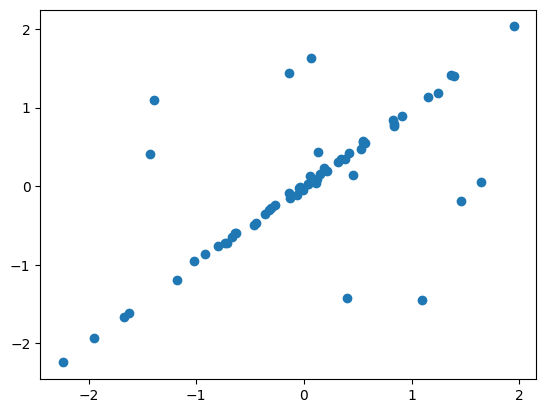

In [258]:
plt.scatter(refF, ref_physnet_F)

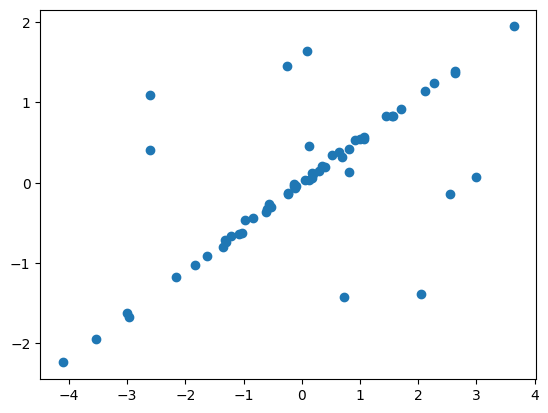

In [259]:
plt.scatter(mF,refF)

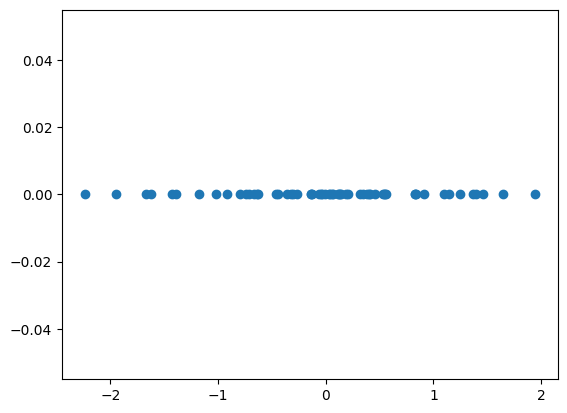

In [260]:
plt.scatter(refF,di["mm_F"])

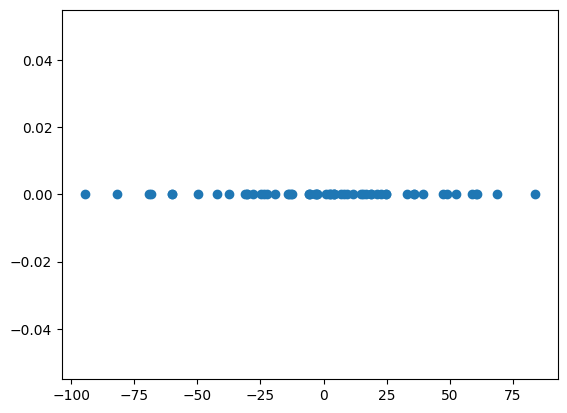

In [213]:
plt.scatter(mF,di["mm_F"])

In [214]:
np.array(dict(ase_atoms.calc.results)["out"].internal_E)*FACTOR + dict(ase_atoms.calc.results)["out"].mm_E

Array gpu:0 -1.886e+03

In [215]:
np.array(dict(ase_atoms.calc.results)["out"].internal_F)

array([[ 1.3902918 ,  0.41300672,  0.41556388],
       [ 0.4707306 ,  0.51073325, -0.42674583],
       [-0.7055305 , -2.2874327 ,  2.0012836 ],
       [-0.08911011,  0.20865971, -1.4190522 ],
       [-1.1698959 ,  1.1641912 ,  0.38002926],
       [ 0.08508101,  1.4654019 , -0.09357724],
       [ 0.22908905, -0.7457456 , -1.6572033 ],
       [-0.6743618 ,  0.13078876, -0.07880037],
       [ 0.9350468 ,  0.08746903,  0.12289125],
       [-0.34787375, -0.93977916,  0.993227  ],
       [ 1.1348267 ,  0.47562435,  1.6239042 ],
       [-0.6091382 ,  0.5505356 ,  0.6061113 ],
       [-1.9697185 , -0.70249224, -1.6219229 ],
       [-1.4363539 ,  0.03497869,  0.02001753],
       [ 1.4678403 , -0.33573204,  0.1512523 ],
       [-0.17433923, -0.28911936,  1.2804847 ],
       [ 0.01909193, -0.09517641, -1.0733865 ],
       [ 0.784367  ,  0.89045393, -0.35498434],
       [ 0.5948633 , -0.5607563 , -0.12819093],
       [ 0.17812903, -0.00299862, -0.5677645 ]], dtype=float32)

In [216]:
view_atoms(ase_atoms)

In [217]:
setupRes.generate_residue("ACO ACO")
ic.build()
coor.show()

***** Generating residue *****
  
 CHARMM>     DELETE ATOM SELE ALL END
  
  
 CHARMM>     read rtf card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/mmml/mmml/data/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/pchem-data/meuwly/boittier/home/mmml/mmml/data/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     read param 

1

In [118]:
test_R

array([[-1.245, -1.674, -7.385],
       [-1.95 ,  0.34 , -6.189],
       [-3.408, -1.718, -6.691],
       [-2.08 , -1.078, -6.721],
       [-4.26 , -1.099, -6.813],
       [-3.541, -2.471, -5.843],
       [-3.45 , -2.432, -7.473],
       [-1.021,  0.419, -5.571],
       [-2.902,  0.607, -5.667],
       [-1.795,  1.06 , -7.068],
       [-0.361, -3.486, -1.491],
       [-0.504, -2.28 , -3.555],
       [-1.473, -4.567, -3.209],
       [-0.714, -3.449, -2.642],
       [-2.433, -4.227, -3.736],
       [-1.786, -5.336, -2.528],
       [-0.792, -5.109, -3.864],
       [ 0.538, -2.059, -3.396],
       [-1.157, -1.423, -3.239],
       [-0.758, -2.525, -4.579]])

In [119]:
xyz = pd.DataFrame(test_R, columns=["x", "y", "z"])
coor.set_positions(xyz)

20

In [120]:
# energy.show()

In [121]:
# coor.show()

In [122]:
nbonds = """!#########################################
! Bonded/Non-bonded Options & Constraints
!#########################################

! Non-bonding parameters
nbonds atom cutnb 14.0  ctofnb 12.0 ctonnb 10.0 -
vswitch NBXMOD 3 -
inbfrq -1 imgfrq -1
"""
pycharmm.lingo.charmm_script(nbonds)

  
 CHARMM>     !#########################################
  
 CHARMM>    ! Bonded/Non-bonded Options & Constraints
 CHARMM>    !#########################################
 CHARMM>     
  
 CHARMM>    ! Non-bonding parameters
 CHARMM>    nbonds atom cutnb 14.0  ctofnb 12.0 ctonnb 10.0 -
 CHARMM>    vswitch NBXMOD 3 -
 CHARMM>    inbfrq -1 imgfrq -1

 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    CDIElec  FSHIft   VATOm    VSWItch 
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  = 14.000 CTEXNB =999.000 CTONNB = 10.000 CTOFNB = 12.000
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      3
 There are        0 atom  pairs and        0 atom  exclusions.
 There are        0 group pairs and        0 group exclusions.
 <MAKINB> with mode   3 found     48 exclusions and      0 interactions(1-4)
 <MAKGRP> found      0 group exclusions.
 Generating nonbond list with Exclusion mode = 3
 == PRIMARY == SPACE FOR   124501 ATOM PAIRS AND    

1

In [123]:
pycharmm_quiet()
energy.show()

  
 CHARMM>     PRNLev 0


In [124]:
energy.get_term_by_name("VDW")

59.06355630766329

In [125]:
energy.get_term_by_name("ELEC")

-50.46871344310568

In [126]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [127]:
pycharmm_verbose()
energy.show()

  
 CHARMM>    WRNLev 5
  

 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    CDIElec  FSHIft   VATOm    VSWItch 
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  = 14.000 CTEXNB =999.000 CTONNB = 10.000 CTOFNB = 12.000
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      3
 There are      142 atom  pairs and       48 atom  exclusions.
 There are        0 group pairs and        0 group exclusions.
 Generating nonbond list with Exclusion mode = 3
 == PRIMARY == SPACE FOR   124501 ATOM PAIRS AND        0 GROUP PAIRS

 General atom nonbond list generation found:
      142 ATOM PAIRS WERE FOUND FOR ATOM LIST
        0 GROUP PAIRS REQUIRED ATOM SEARCHES

 EPHI: WARNING. bent improper torsion angle is 

far from minimum for;
    IPHI=    1  with deltaPHI=-168.1098 MIN=   0.0000 ATOMS:    2    3    4    1
 EPHI: WARNING. bent improper torsion angle is 

far from minimum for;
    IPHI=    2  with deltaPHI= 176.4877 MIN=   0.0000 ATOMS:  

In [128]:
CLEAR_CHARMM()

  
 CHARMM>     DELETE ATOM SELE ALL END
 SELRPN>     20 atoms have been selected out of     20

 Message from MAPIC: Atom numbers are changed.

 Message from MAPIC:          2 residues deleted.

 Message from MAPIC:          1 segments deleted.
 DELTIC:        18 bonds deleted
 DELTIC:        30 angles deleted
 DELTIC:        24 dihedrals deleted
 DELTIC:         2 improper dihedrals deleted
 DELTIC:         2 acceptors deleted
 PSFSUM> PSF modified: NONBOND lists and IMAGE atoms cleared.
 PSFSUM> Summary of the structure file counters :
         Number of segments      =        0   Number of residues   =        0
         Number of atoms         =        0   Number of groups     =        0
         Number of bonds         =        0   Number of angles     =        0
         Number of dihedrals     =        0   Number of impropers  =        0
         Number of cross-terms   =        0   Number of autogens   =        0
         Number of HB acceptors  =        0   Number of HB donors

In [129]:
atoms = setupRes.main("ACO")

***** Generating residue from residue name (ACO) *****
***** Generating residue *****
  
 CHARMM>     DELETE ATOM SELE ALL END
  
  
 CHARMM>     read rtf card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/mmml/mmml/data/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/pchem-data/meuwly/boittier/home/mmml/mmml/data/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status

In [130]:
atoms = setupRes.generate_coordinates()
_ = setupRes.coor.get_positions()
atoms.set_positions(_)
reset_block()
reset_block_no_internal()
reset_block()

***** Generating coordinates *****

          COORDINATE FILE MODULE
 TITLE>  * EXECUTING CHARMM SCRIPT FROM PYTHON
 TITLE>  *  DATE:    12/ 8/25     22: 4:37      CREATED BY USER: boittier
 TITLE>  *
        10  EXT
         1         1  ACO       O1              1.2572267006        0.9914799389       -0.8862359995  ACO       1               0.0000000000
         2         1  ACO       C1              0.6810734606        0.5951225741        0.1229186041  ACO       1               0.0000000000
         3         1  ACO       C2             -0.7588496083        0.2019696047        0.0900039727  ACO       1               0.0000000000
         4         1  ACO       C3              1.3859957201        0.4777291766        1.4282821584  ACO       1               0.0000000000
         5         1  ACO       H21            -0.8447488573       -0.8987249657        0.2077055292  ACO       1               0.0000000000
         6         1  ACO       H22            -1.3055527785        0.71015868

In [131]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [132]:
atoms = setupRes.generate_coordinates()
_ = setupRes.coor.get_positions()
atoms.set_positions(_)
reset_block()
reset_block_no_internal()
reset_block()


***** Generating coordinates *****

          COORDINATE FILE MODULE
 TITLE>  * EXECUTING CHARMM SCRIPT FROM PYTHON
 TITLE>  *
        10  EXT
         1         1  ACO       O1              0.0956940678        1.9554615692        1.9739202501  ACO       1               0.0000000000
         2         1  ACO       C1              0.2106266770        1.0166261491        1.1973738707  ACO       1               0.0000000000
         3         1  ACO       C2              0.4424885496       -0.3736832169        1.6866537226  ACO       1               0.0000000000
         4         1  ACO       C3              0.1075604091        1.2050481419       -0.2757982820  ACO       1               0.0000000000
         5         1  ACO       H21             1.2960193799       -0.8307896002        1.1426741568  ACO       1               0.0000000000
         6         1  ACO       H22            -0.4684588906       -0.9836923929        1.5381382237  ACO       1               0.0000000000
         7 

In [133]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [134]:
energy.show()


 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    CDIElec  FSWItch  VATOm    VFSWIt  
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  = 18.000 CTEXNB =999.000 CTONNB = 13.000 CTOFNB = 17.000
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      5
 There are       21 atom  pairs and       36 atom  exclusions.
 There are        0 group pairs and        0 group exclusions.
 Generating nonbond list with Exclusion mode = 5
 == PRIMARY == SPACE FOR   124501 ATOM PAIRS AND        0 GROUP PAIRS

 General atom nonbond list generation found:
       21 ATOM PAIRS WERE FOUND FOR ATOM LIST
        0 GROUP PAIRS REQUIRED ATOM SEARCHES

 PRNHBD: CUToff Hydrogen Bond  distance =    0.5000   Angle =   90.0000
         CuT switching ON HB dist. =     3.5000  OFf HB dist. =    4.0000
         CuT switching ON Hb Angle =    50.0000  OFf Hb Angle =   70.0000
         ACCEptor antecedents included
         All hydrogen bonds for each hydrogen will be

In [135]:
energy.get_term_by_name("VDW")

-0.28053929860832777

In [136]:
pycharmm.lingo.get_energy_value("ENER")

-29.804747564495496

# Example: packmol for a dimer system

In [152]:
run_packmol(20, 30)

NameError: name 'run_packmol' is not defined

In [153]:
def CLEAR_CHARMM():
    s = """DELETE ATOM SELE ALL END"""
    pycharmm.lingo.charmm_script(s)
    s = """DELETE PSF SELE ALL END"""
    pycharmm.lingo.charmm_script(s)

CLEAR_CHARMM()

  
 CHARMM>     DELETE ATOM SELE ALL END
  
  
 CHARMM>     DELETE PSF SELE ALL END
  


In [154]:
reset_block()
reset_block_no_internal()
reset_block()
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

  
 CHARMM>     BLOCK
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>      0 atoms have been selected out of      0
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ANGLE Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of DIHE Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of CROSS Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ELEC Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of VDW Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 

In [155]:
# pycharmm_verbose()

In [156]:
# pycharmm.lingo.charmm_script(nbonds)

# #equivalent CHARMM scripting command: minimize abnr nstep 1000 tole 1e-3 tolgr 1e-3
# minimize.run_abnr(nstep=1000, tolenr=1e-1, tolgrd=1e-1)
# #equivalent CHARMM scripting command: energy
# energy.show()

In [158]:
mmml.pycharmmInterface.import_pycharmm.view_pycharmm_state()

In [159]:
ase_atoms.set_positions(coor.get_positions())
view_atoms(ase_atoms)

ValueError: Array "positions" has wrong shape (0, 3) != (20, 3).

In [160]:
cs

NameError: name 'cs' is not defined

In [161]:
ase_atoms.get_potential_energy()

Array gpu:0 -1.828e+03

In [162]:
ase_atoms.calc.results #["out"]

{'out': ModelOutput(energy=Array gpu:0 -79.291, forces=Array[20, 3] n=60 x∈[-4.573, 5.134] μ=-0.012 σ=1.822 gpu:0, dH=Array gpu:0 0.556, internal_E=Array gpu:0 -79.847, internal_F=Array[20, 3] n=60 x∈[-3.189, 2.986] μ=-0.012 σ=1.120 gpu:0, mm_E=Array gpu:0 0., mm_F=Array[20, 3] n=60 all_zeros gpu:0, ml_2b_E=Array gpu:0 0.556, ml_2b_F=Array[20, 3] n=60 x∈[-2.204, 2.148] μ=1.589e-08 σ=0.772 gpu:0),
 'energy': Array gpu:0 -1.828e+03,
 'forces': array([[ -12.23292923,  -22.04220581,    9.43237877],
        [  22.2571106 ,   23.19558716,  -26.62253761],
        [   6.39198112, -105.44754028,    4.44868898],
        [ -48.87638474,  118.384758  ,   40.71484756],
        [   6.34871244,   26.5374012 ,   25.52165794],
        [  22.63877487,   56.98601151,    7.62734413],
        [   3.37983465,  -31.53526878,  -68.0436554 ],
        [ -40.34270096,  -14.19344234,   -2.39501047],
        [  55.55786514,  -16.95151711,   -6.70579243],
        [  -8.82472038,  -42.26828766,   29.18711281],
     

In [163]:
ase_atoms.calc.results["out"].mm_E

Array gpu:0 0.

In [164]:
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(ase_atoms).run(fmax=0.001)

NameError: name 'ase_opt' is not defined

In [165]:
view_atoms(ase_atoms)

In [166]:
# Parameters.
temperature = 10
timestep_fs = 0.1
num_steps = 300

# Draw initial momenta.
MaxwellBoltzmannDistribution(ase_atoms, temperature_K=temperature)
Stationary(ase_atoms)  # Remove center of mass translation.
ZeroRotation(ase_atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(ase_atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(ase_atoms), 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = ase_atoms.get_positions()
  potential_energy[i] = ase_atoms.get_potential_energy()
  kinetic_energy[i] = ase_atoms.get_kinetic_energy()
  total_energy[i] = ase_atoms.get_total_energy()
  # Occasionally print progress.
  if i % 100 == 0:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

NameError: name 'MaxwellBoltzmannDistribution' is not defined

In [149]:
# # Visualize the structure with py3Dmol.
# view = py3Dmol.view()
# xyz = io.StringIO()
# ase_io.write(xyz, ase_atoms, format='xyz')
# view.addModel(xyz.getvalue(), 'xyz')
# view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
# view.show()
# view.getModel().setCoordinates(frames[::100], 'array')
# view.animate({'loop': 'forward', 'interval': 0.1})
# view.show() 

NameError: name 'num_steps' is not defined

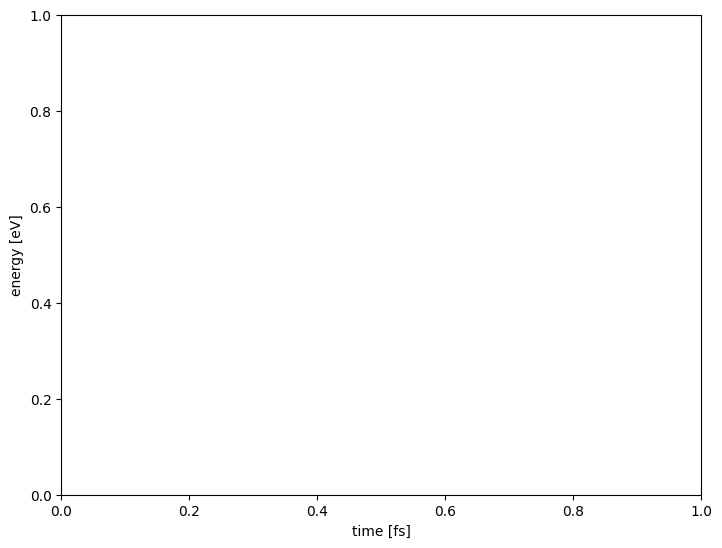

In [150]:
%matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy, label='potential energy')
plt.plot(time, kinetic_energy, label='kinetic energy')
plt.plot(time, total_energy, label='total energy')
plt.legend()
plt.grid()

In [151]:
view_atoms(ase_atoms)